In [1]:
!pip install pyupbit
!pip install tensorflow

     |████████████████████████████████| 103 kB 11.8 MB/s 


In [2]:
def get_candle_15minutes(coin_ticker, n_count) :
  url = "https://api.upbit.com/v1/candles/minutes/15"

  querystring = {"market":"KRW-" + coin_ticker ,"count" : str(n_count)}

  response = requests.request("GET", url, params=querystring)

  return response.json()
  print(response.json())

def get_candle_1day(coin_ticker, n_count) :
  url = "https://api.upbit.com/v1/candles/days"

  querystring = {"market":"KRW-" + coin_ticker ,"count" : str(n_count)}

  response = requests.request("GET", url, params=querystring)

  return response.json()
  print(response.json())

In [3]:
import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import pyupbit
import requests

df = pd.DataFrame(get_candle_15minutes('BTC', 200))

In [4]:
df.head()

,market,candle_date_time_utc,candle_date_time_kst,opening_price,high_price,low_price,trade_price,timestamp,candle_acc_trade_price,candle_acc_trade_volume,unit
0,KRW-BTC,2022-02-03T04:00:00,2022-02-03T13:00:00,45524000.0,45597000.0,45500000.0,45551000.0,1643861069864,6.488016e+08,14.249447,15
1,KRW-BTC,2022-02-03T03:45:00,2022-02-03T12:45:00,45545000.0,45604000.0,45507000.0,45524000.0,1643860799860,1.327372e+09,29.146851,15
2,KRW-BTC,2022-02-03T03:30:00,2022-02-03T12:30:00,45554000.0,45641000.0,45530000.0,45545000.0,1643859900049,1.444440e+09,31.690203,15
3,KRW-BTC,2022-02-03T03:15:00,2022-02-03T12:15:00,45652000.0,45683000.0,45551000.0,45554000.0,1643858999929,9.009350e+08,19.747627,15
4,KRW-BTC,2022-02-03T03:00:00,2022-02-03T12:00:00,45682000.0,45748000.0,45585000.0,45652000.0,1643858099963,1.376862e+09,30.147694,15


In [5]:
df = pd.DataFrame(get_candle_15minutes('BTC', 200))
df = df[['candle_date_time_kst', 'opening_price', 'high_price', 'low_price', 'candle_acc_trade_volume', 'trade_price']]
df.set_index('candle_date_time_kst')
df = df.sort_index(ascending=False)
df = df.reset_index()
df = df.drop('index',axis=1).drop('candle_date_time_kst',axis=1)
df.head(5)

,opening_price,high_price,low_price,candle_acc_trade_volume,trade_price
0,47200000.0,47324000.0,47193000.0,22.543420,47304000.0
1,47303000.0,47469000.0,47300000.0,29.876380,47400000.0
2,47401000.0,47451000.0,47381000.0,19.138824,47422000.0
3,47427000.0,47454000.0,47323000.0,24.081239,47454000.0
4,47454000.0,47514000.0,47400000.0,54.656669,47450000.0


In [6]:
# 정규화 함수 
def MinMaxScaler(data):
    denom = np.max(data,0)-np.min(data,0)
    nume = data-np.min(data,0)
    return nume/denom

# 정규화 되돌리기 함수 
def back_MinMax(data,value):
    diff = np.max(data,0)-np.min(data,0)
    back = value * diff + np.min(data,0)
    return back 

In [7]:
df = np.array(df)
df

array([[4.72000000e+07, 4.73240000e+07, 4.71930000e+07, 2.25434195e+01,
        4.73040000e+07],
       [4.73030000e+07, 4.74690000e+07, 4.73000000e+07, 2.98763802e+01,
        4.74000000e+07],
       [4.74010000e+07, 4.74510000e+07, 4.73810000e+07, 1.91388241e+01,
        4.74220000e+07],
       [4.74270000e+07, 4.74540000e+07, 4.73230000e+07, 2.40812391e+01,
        4.74540000e+07],
       [4.74540000e+07, 4.75140000e+07, 4.74000000e+07, 5.46566690e+01,
        4.74500000e+07],
       [4.74500000e+07, 4.74510000e+07, 4.73800000e+07, 2.88422475e+01,
        4.74050000e+07],
       [4.73810000e+07, 4.75400000e+07, 4.73810000e+07, 3.33228514e+01,
        4.75000000e+07],
       [4.75000000e+07, 4.75600000e+07, 4.74710000e+07, 3.19037445e+01,
        4.75180000e+07],
       [4.75180000e+07, 4.75250000e+07, 4.73970000e+07, 2.56436684e+01,
        4.73980000e+07],
       [4.74000000e+07, 4.74090000e+07, 4.73120000e+07, 2.64196858e+01,
        4.73520000e+07],
       [4.73520000e+07, 4.7410

In [8]:
%matplotlib notebook
plt.plot(df[:,4]) # 전체 종가
print(df.shape)

<IPython.core.display.Javascript object>

(200, 5)


In [9]:
seqLength = 10 # window size 
dataDim = 5 # 시가, 고가, 저가, 거래량 , 종가
hiddenDim = 10 
outputDim = 1
lr = 0.01
iterations = 200

trainSize = int(len(df)*0.7)
trainSet = df[0:trainSize]
testSet = df[trainSize-seqLength:]

trainSet = MinMaxScaler(trainSet)
testSet = MinMaxScaler(testSet)


# 200개의 5가지 데이터(시가, 종가, 고가, 저가, 거래량)를 받아와서 
# 바로 다음 날의 종가를 예측하는 모델로 구성

def buildDataSet(timeSeries, seqLength):
    xdata = []
    ydata = [] 
    for i in range(0, len(timeSeries)-seqLength):
        tx = timeSeries[i:i+seqLength,:-1]
        ty = timeSeries[i+seqLength,[-1]]
        xdata.append(tx)
        ydata.append(ty)
    return np.array(xdata), np.array(ydata)
    
trainX, trainY=buildDataSet(trainSet, seqLength)
testX, testY=buildDataSet(testSet, seqLength)

In [10]:
trainSet[0:]

array([[1.69027384e-01, 1.66519824e-01, 3.07984791e-01, 7.97615428e-02,
        2.48789932e-01],
       [2.66288952e-01, 2.94273128e-01, 4.09695817e-01, 1.18711828e-01,
        3.41723136e-01],
       [3.58829084e-01, 2.78414097e-01, 4.86692015e-01, 6.16774471e-02,
        3.63020329e-01],
       [3.83380548e-01, 2.81057269e-01, 4.31558935e-01, 8.79299367e-02,
        3.93998064e-01],
       [4.08876298e-01, 3.33920705e-01, 5.04752852e-01, 2.50336605e-01,
        3.90125847e-01],
       [4.05099150e-01, 2.78414097e-01, 4.85741445e-01, 1.13218853e-01,
        3.46563408e-01],
       [3.39943343e-01, 3.56828194e-01, 4.86692015e-01, 1.37018354e-01,
        4.38528558e-01],
       [4.52313503e-01, 3.74449339e-01, 5.72243346e-01, 1.29480523e-01,
        4.55953533e-01],
       [4.69310670e-01, 3.43612335e-01, 5.01901141e-01, 9.62290491e-02,
        3.39787028e-01],
       [3.57884797e-01, 2.41409692e-01, 4.21102662e-01, 1.00350999e-01,
        2.95256534e-01],
       [3.12559018e-01, 2.4229

In [14]:
# 모델 구성 

# First, let's define a RNN Cell, as a layer subclass.
from tensorflow import keras
from tensorflow.keras import layers

model = keras.Sequential()

model.add(layers.SimpleRNN(units=10, 
                           activation='tanh',
                           input_shape=[10,4]))

model.add(layers.Dense(1))

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_1 (SimpleRNN)    (None, 10)                150       
                                                                 
 dense_1 (Dense)             (None, 1)                 11        
                                                                 
Total params: 161
Trainable params: 161
Non-trainable params: 0
_________________________________________________________________


In [15]:
trainX

array([[[0.16902738, 0.16651982, 0.30798479, 0.07976154],
        [0.26628895, 0.29427313, 0.40969582, 0.11871183],
        [0.35882908, 0.2784141 , 0.48669202, 0.06167745],
        ...,
        [0.4523135 , 0.37444934, 0.57224335, 0.12948052],
        [0.46931067, 0.34361233, 0.50190114, 0.09622905],
        [0.3578848 , 0.24140969, 0.42110266, 0.100351  ]],

       [[0.26628895, 0.29427313, 0.40969582, 0.11871183],
        [0.35882908, 0.2784141 , 0.48669202, 0.06167745],
        [0.38338055, 0.28105727, 0.43155894, 0.08792994],
        ...,
        [0.46931067, 0.34361233, 0.50190114, 0.09622905],
        [0.3578848 , 0.24140969, 0.42110266, 0.100351  ],
        [0.31255902, 0.24229075, 0.44106464, 0.06940716]],

       [[0.35882908, 0.2784141 , 0.48669202, 0.06167745],
        [0.38338055, 0.28105727, 0.43155894, 0.08792994],
        [0.4088763 , 0.3339207 , 0.50475285, 0.25033661],
        ...,
        [0.3578848 , 0.24140969, 0.42110266, 0.100351  ],
        [0.31255902, 0.242290

In [16]:
# 모델 학습과정 설정 
model.compile(loss='mse', optimizer='adam', metrics=['mae'])

# 모델 트레이닝 
hist = model.fit(trainX, trainY, epochs=1000, batch_size=16)

Epoch 1/1000
9/9 [==============================] - 1s 3ms/step - loss: 0.3776 - mae: 0.5568
Epoch 2/1000
9/9 [==============================] - 0s 3ms/step - loss: 0.1776 - mae: 0.3674
Epoch 3/1000
9/9 [==============================] - 0s 3ms/step - loss: 0.0734 - mae: 0.2253
Epoch 4/1000
9/9 [==============================] - 0s 3ms/step - loss: 0.0432 - mae: 0.1613
Epoch 5/1000
9/9 [==============================] - 0s 3ms/step - loss: 0.0430 - mae: 0.1629
Epoch 6/1000
9/9 [==============================] - 0s 3ms/step - loss: 0.0393 - mae: 0.1558
Epoch 7/1000
9/9 [==============================] - 0s 4ms/step - loss: 0.0354 - mae: 0.1459
Epoch 8/1000
9/9 [==============================] - 0s 3ms/step - loss: 0.0338 - mae: 0.1433
Epoch 9/1000
9/9 [==============================] - 0s 3ms/step - loss: 0.0322 - mae: 0.1392
Epoch 10/1000
9/9 [==============================] - 0s 3ms/step - loss: 0.0303 - mae: 0.1345
Epoch 11/1000
9/9 [==============================] - 0s 4ms/step - lo

In [17]:
# 모델 테스트 
res = model.evaluate(testX, testY, batch_size=16)
print("loss",res[0],"mae",res[1])

4/4 [==============================] - 0s 3ms/step - loss: 0.0749 - mae: 0.2276
loss 0.07493486255407333 mae 0.22755736112594604


In [18]:
#7 모델 사용
xhat = testX
yhat = model.predict(xhat)
print(testY)
print(yhat)

print("Evaluate : {}".format(np.average((yhat - testY)**2)))

[[9.14192950e-01]
 [8.99350649e-01]
 [8.32096475e-01]
 [8.41372913e-01]
 [8.33951763e-01]
 [5.97402597e-01]
 [5.06029685e-01]
 [4.93970315e-01]
 [5.11595547e-01]
 [4.09554731e-01]
 [3.34879406e-01]
 [2.45361781e-01]
 [3.02875696e-01]
 [2.64378479e-01]
 [3.58534323e-01]
 [4.41094620e-01]
 [4.16048237e-01]
 [3.59461967e-01]
 [3.91465677e-01]
 [4.19294991e-01]
 [3.87755102e-01]
 [3.97031540e-01]
 [4.24860853e-01]
 [4.10018553e-01]
 [4.33209647e-01]
 [4.51762523e-01]
 [4.44341373e-01]
 [4.91187384e-01]
 [4.26716141e-01]
 [4.10018553e-01]
 [4.43413729e-01]
 [3.92393321e-01]
 [3.12615955e-01]
 [7.42115028e-02]
 [1.44248609e-01]
 [1.51669759e-01]
 [1.78107607e-01]
 [2.45361781e-01]
 [1.45640074e-01]
 [1.63265306e-01]
 [8.07050093e-02]
 [1.85528757e-03]
 [4.63821892e-04]
 [6.21521336e-02]
 [1.21521336e-01]
 [6.30797774e-02]
 [3.06122449e-02]
 [1.85528757e-03]
 [2.82931354e-02]
 [9.27643785e-02]
 [6.16883117e-02]
 [1.62337662e-02]
 [0.00000000e+00]
 [3.15398887e-02]
 [7.51391466e-02]
 [6.307977

In [19]:
# 원래 값으로 되돌리기 
predict = back_MinMax(df[trainSize-seqLength:,[-1]],yhat)
actual = back_MinMax(df[trainSize-seqLength:,[-1]],testY)
print("예측값",predict)
print("실제값",actual)

print(predict.shape)
print(actual.shape)

예측값 [[47331900.61545372]
 [47261545.3953743 ]
 [47310991.01305008]
 [47232347.82290459]
 [47178129.4324398 ]
 [47144015.41566849]
 [46601110.0692749 ]
 [46331619.45033073]
 [47021594.56467628]
 [46727831.42757416]
 [46759006.21819496]
 [47044771.29840851]
 [46724334.73539352]
 [46539563.40360641]
 [46546633.12149048]
 [46874965.44933319]
 [47092842.52715111]
 [47092089.98656273]
 [46976098.37150574]
 [46892033.57362747]
 [46838692.76165962]
 [46820807.45744705]
 [46889427.05368996]
 [46855151.50284767]
 [46813893.61929893]
 [46754493.28780174]
 [46864239.56131935]
 [46921380.60045242]
 [46911546.42677307]
 [46869491.02497101]
 [46805121.04701996]
 [46939296.74649239]
 [46783117.97332764]
 [46647783.52069855]
 [46312015.3567791 ]
 [46315018.70822906]
 [46183308.94136429]
 [46218121.52552605]
 [46356898.18310738]
 [46272986.82332039]
 [45862781.65197372]
 [45861281.58259392]
 [45979485.71324348]
 [45951931.27125502]
 [45930141.96997881]
 [46122098.83713722]
 [46305954.03814316]
 [4602738

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.7/dist-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['hist']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


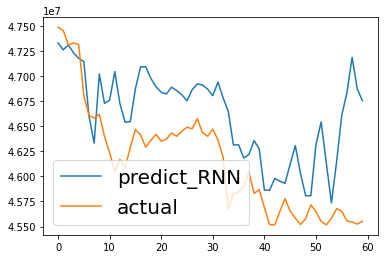

In [40]:
%matplotlib inline
%pylab inline
plt.figure()
plt.plot(predict[:60], label = "predict_RNN")
plt.plot(actual[:60],label = "actual")

plt.legend(prop={'size': 20})

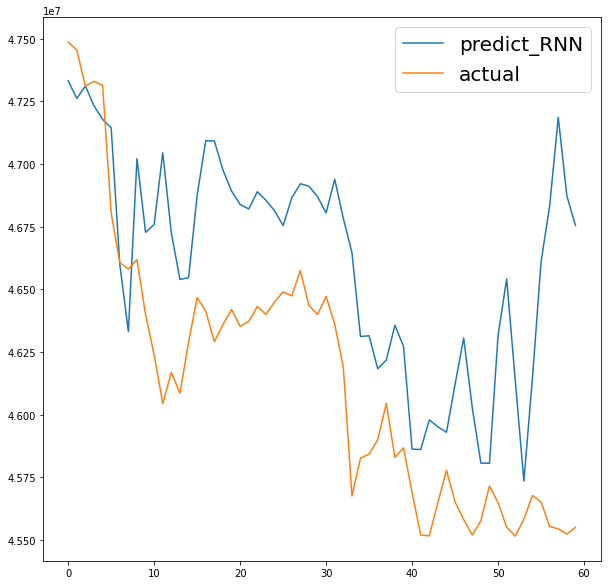

In [41]:
fig = plt.figure(figsize=(10,10))
chart = fig.add_subplot(1,1,1)
chart.plot(predict[:60], label = "predict_RNN")
chart.plot(actual[:60], label="actual")
chart.legend(prop={'size': 20})